In [28]:
import h5py
from clustering_methods import grassmannian_clustering_gruber2006
from tqdm import tqdm
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline


<div style="text-align:center; font-size:24px;">Loading the eigenvects and clustering data using grassmann clustering</div>

In [29]:
# Only dealing with data from sleep_run's for each subject
# All data has sample size 429

cluster_numbers = [2, 3, 4, 5, 6, 8, 10, 12, 15]
number_of_subjects = 33 
run_number = [2, 3, 4, 5] # sleep-run-numbers
all_data_matrices = {} # lib to hold all the sleep_stage data for each subject
valid_data_lib = {} # holds information about each subject and for what sleep stage runs we have data // valid_data_lib['01] - subject 1

for subject in tqdm(range(1, number_of_subjects + 1)):
    subject = str(subject).zfill(2) # fill 01, 02 and so on

    all_data_matrices[subject] = {}
    valid_data_lib[subject] = []

    for number in run_number:
        data_matrix = []
        with open(f"sleep_data/sleep_scores/sub-{subject}-sleep-stage.tsv", "r", newline="", encoding="utf-8") as tsv_file: # needs to do this for every number othervise it does not work
            tsv_reader = csv.reader(tsv_file, delimiter="\t")
            next(tsv_reader) # skip first row to remove column names
            for row in tsv_reader:
                if subject != "01":
                    if row[0] == f'task-sleep_run-{number}': 
                        data_matrix.append(row)
                else:
                    if row[1] == f'task-sleep_run-{number}': # We do this to handle the case where the first collumn is not 'task-sleep_run-x' as is the case for subject 1
                        data_matrix.append(row)   
            if len(data_matrix)>0:        
                all_data_matrices[subject][number] = data_matrix
                valid_data_lib[subject].append(number)

for number in run_number: # removing first collumn in data for subject "01" as it contains an extra collumn compared to the rest of the data
    try: 
        all_data_matrices["01"][number] = [row[1:] for row in all_data_matrices["01"][number]]
    except:
        continue

for subject in all_data_matrices: # removing subjects with no data for sleep stages at all
    numbers_to_remove = []
    for number in valid_data_lib[subject]: # removing sleep stages that contain a constant state 
        if len(np.unique([s[0] for s in np.array(all_data_matrices[subject][number])[:, 2]])) == 1:
            numbers_to_remove.append(number)
    for number in numbers_to_remove:
        valid_data_lib[subject].remove(number)
    if valid_data_lib[subject] == []:
        valid_data_lib.pop(subject)

# removing some subjects manually if they seem to contain to much noise or are awake almost all the time - this will not be caught above
valid_data_lib.pop('11')
valid_data_lib.pop('23')
valid_data_lib.pop('27')
valid_data_lib.pop('20')
valid_data_lib.pop('03')
valid_data_lib.pop('07')

valid_data_lib = {key: value for key, value in valid_data_lib.items() if len(value) >= len(run_number)} # finally we remove all subjects where we dont have valid data for all (4) runs

print(len(valid_data_lib)) # number of subjects left



100%|██████████| 33/33 [00:00<00:00, 1571.94it/s]

13


In [30]:
cluster_assignments_objfunc = {} # holds the cluster assignments and objectibe function value for each subject for each number og clusters

for subject in tqdm(valid_data_lib):
    subject_data_matrix = []
    cluster_assignments_objfunc[subject] = {}
    for number in valid_data_lib[subject]:
        with h5py.File(f"sleep_data/eigvecs/sub-{subject}_session-task-sleep_run-{number}_eigvecs.h5", "r") as file: # henter data
            data = file['eigvecs'][:]
            subject_data_matrix.append(data)
    subject_data_matrix = np.vstack(subject_data_matrix) # prep data matrix for grassman func

    for cluster in cluster_numbers: # clustering the combined data for each subject
        C, part, obj = grassmannian_clustering_gruber2006(subject_data_matrix, cluster, max_iter=1000)
        cluster_assignments_objfunc[subject][f'cluster_{cluster}_assignments'] = part
        cluster_assignments_objfunc[subject][f'cluster_{cluster}_objfunc'] = obj

100%|██████████| 13/13 [1:45:43<00:00, 487.94s/it]


<div style="text-align:center; font-size:24px;">Using Objective Function Value as meassure for preformance</div>

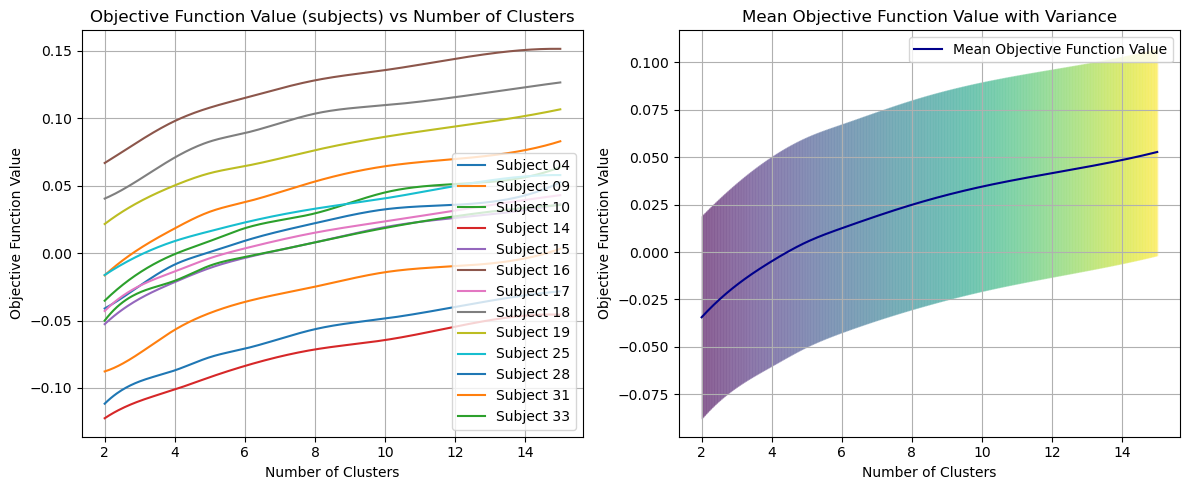

In [32]:
# Create a figure with (1, 2) subplot arrangement
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

obj_val_list = []
# Plot individual objective function values
for subject in valid_data_lib:
    obj_vals = [cluster_assignments_objfunc[subject][f'cluster_{cluster}_objfunc'] for cluster in cluster_numbers]
    obj_val_list.append(obj_vals)

    # Interpolation for smoothing
    x_smooth = np.linspace(min(cluster_numbers), max(cluster_numbers), 300)  # 300 points for smooth curve
    spline = make_interp_spline(cluster_numbers, obj_vals, k=3)
    smooth_obj_vals = spline(x_smooth)
        
    axes[0].plot(x_smooth, smooth_obj_vals, label=f'Subject {subject}')  # Plot the smoothed values

# Compute mean and variance across subjects for each number of clusters
obj_val_array = np.array(obj_val_list)
mean_values = np.mean(obj_val_array, axis=0) 
variance_values = np.var(obj_val_array, axis=0)
std_dev = np.sqrt(variance_values)

# Interpolation for smoothing
x_smooth = np.linspace(min(cluster_numbers), max(cluster_numbers), 300)  # 300 points for smooth curve

# Create splines for mean and standard deviation
mean_spline = make_interp_spline(cluster_numbers, mean_values, k=3)
std_spline = make_interp_spline(cluster_numbers, std_dev, k=3)

# Evaluate splines
smooth_mean = mean_spline(x_smooth)
smooth_std = std_spline(x_smooth)

# Plot the smoothed mean and variance with gradient color
cmap = plt.get_cmap('viridis')

# Fill between for the smooth standard deviation
for i in range(len(x_smooth) - 1):
    axes[1].fill_between(x_smooth[i:i+2], 
                         smooth_mean[i:i+2] - smooth_std[i:i+2], 
                         smooth_mean[i:i+2] + smooth_std[i:i+2],
                         color=cmap(i / len(x_smooth)), 
                         alpha=0.3)

axes[1].plot(x_smooth, smooth_mean, label='Mean Objective Function Value', color='darkblue')

# Add labels and title for subplot 1
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Objective Function Value')
axes[0].set_title('Objective Function Value (subjects) vs Number of Clusters')
axes[0].legend()
axes[0].grid(True)

# Add labels and title for subplot 2
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Objective Function Value')
axes[1].set_title('Mean Objective Function Value with Variance')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

<div style="text-align:center; font-size:24px;">Using NMI as meassure for preformance</div>


In [33]:
# bud på en sequence til at fitte 30 sekund intervaller til 429 samples
# sums to 429

sequence = [14, 14, 14, 15, 14, 14, 14, 15, 14, 14, 15, 15, 14, 14, 14, 15, 14, 14, 14, 15, 14, 14, 15, 15, 14, 14, 14, 15, 14, 14]

for subject in valid_data_lib:
    for number in valid_data_lib[subject]:
        repeated_data = np.repeat(np.array(all_data_matrices[subject][number])[:, 2], sequence)
        all_data_matrices[subject][number] = repeated_data   

<div style="text-align:center; font-size:24px;">1 out of K encoding of the true labels</div>

In [34]:
number_of_sleep_stages = 3 # number of possible sleep_stages 

possible_sleep_stages = ['W'] + [str(i) for i in range(1, number_of_sleep_stages)]

encoded_matrices = {} # new lib to keep 1 out of k encoded matrices

for subject in valid_data_lib:
    encoded_matrices[subject] = {}
    for number in valid_data_lib[subject]:
        subject_matrix = np.zeros((len(possible_sleep_stages), len(all_data_matrices[subject][number])), dtype=int) # this will be (3, 429) as everything is right now
        for i, stage in enumerate(all_data_matrices[subject][number]):
            try: 
                stage_index = possible_sleep_stages.index(stage) # Find the index of the stage in the possible_sleep_stages list
            except:
                try:
                    stage_index = possible_sleep_stages.index(stage[0]) # here we take care of the data very we have '1 uncertain' or 'W uncertain'
                except:
                    stage_index = possible_sleep_stages.index('W') # justify why we do this ///////
            subject_matrix[stage_index, i] = 1 # Set the corresponding element in the subject_matrix to 1
        encoded_matrices[subject][number] = subject_matrix


<div style="text-align:center; font-size:24px;">1 out of K encoding of predicted labels using grassmann clustering</div>

In [35]:

encoded_predictions = {} # holds 1 out of k encoded predictions

for subject in valid_data_lib:
    encoded_predictions[subject] = {} # we encode predictions for each subject
    for cluster in cluster_numbers:
        data = cluster_assignments_objfunc[subject][f'cluster_{cluster}_assignments'] # data is the output from the grassmann clustering func
        encoded_predictions[subject][cluster] = {}
        possible_clusters = list(range(cluster))
        subject_cluster_matrix = np.zeros((cluster, len(data))) # creates empty matrix with rows corresponding to number of clusters
        for i, stage in enumerate(data): # 1 out of k encoding here
            stage_index = possible_clusters.index(stage)
            subject_cluster_matrix[stage_index, i] = 1
        encoded_predictions[subject][cluster] = subject_cluster_matrix # saves encoded data


<div style="text-align:center; font-size:24px;">Calculating NMI</div>

In [36]:
def calc_MI(Z1, Z2):
    P = Z1 @ Z2.T # joint probability matrix
    PXY = P / np.sum(P) # joint probability matrix normalized
    PXPY = np.outer(np.sum(PXY,axis=1),np.sum(PXY,axis=0)) # product of marginals
    ind = np.where(PXY > 0) # non-zero elements
    MI = np.sum(PXY[ind] * np.log(PXY[ind]/PXPY[ind])) # mutual information
    return MI

def calc_NMI(Z1, Z2):
    # Z1 and Z2 are two partition matrices of size (KxN) where K is number of components and N is number of samples

     ###### to handle runtime error
    if np.mean([calc_MI(Z1,Z1), calc_MI(Z2,Z2)]) == 0:
        return 0

    NMI = calc_MI(Z1,Z2) / np.mean([calc_MI(Z1,Z1), calc_MI(Z2,Z2)])

    return NMI


NMI_scores = {}

for subject in valid_data_lib:
    NMI_scores[subject] = {}
    subject_encoded_true_labels = []
    for number in valid_data_lib[subject]: # since we combine all the data within each subject, we use hstack here
        subject_encoded_true_labels.append(encoded_matrices[subject][number])
    combined_subject_encoded_true_labels = np.hstack(subject_encoded_true_labels)
    for cluster in cluster_numbers:
        score = calc_NMI(combined_subject_encoded_true_labels, encoded_predictions[subject][cluster])
        NMI_scores[subject][cluster] = score

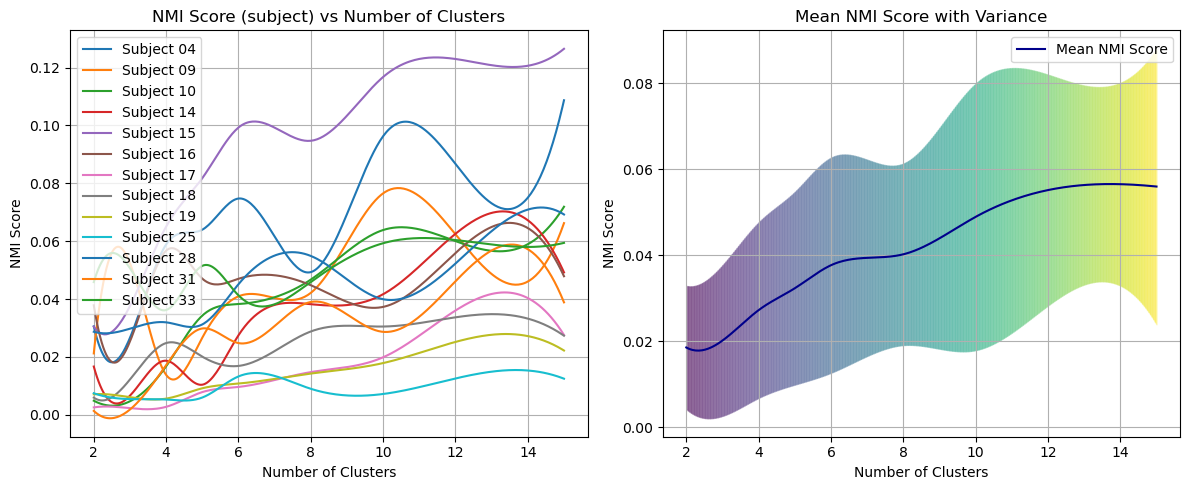

In [38]:
# Create a figure with (1, 2) subplot arrangement
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

NMI_score_list = []

# Plot individual NMI scores
for subject in valid_data_lib:
    NMI_score = [NMI_scores[subject][cluster] for cluster in cluster_numbers]
    NMI_score_list.append(NMI_score)
    # Interpolation for smoothing
    x_smooth = np.linspace(min(cluster_numbers), max(cluster_numbers), 300)  # 300 points for smooth curve
    spline = make_interp_spline(cluster_numbers, NMI_score, k=3)
    smooth_NMI_score = spline(x_smooth)
        
    axes[0].plot(x_smooth, smooth_NMI_score, label=f'Subject {subject}')  # Plot the smoothed values

# Compute mean and variance across subjects for each number of clusters
NMI_score_array = np.array(NMI_score_list)
mean_values = np.mean(NMI_score_array, axis=0)
variance_values = np.var(NMI_score_array, axis=0)
std_dev = np.sqrt(variance_values)

# Interpolation for smoothing
x_smooth = np.linspace(min(cluster_numbers), max(cluster_numbers), 300)  # 300 points for smooth curve

# Create splines for mean and standard deviation
mean_spline = make_interp_spline(cluster_numbers, mean_values, k=3)
std_spline = make_interp_spline(cluster_numbers, std_dev, k=3)

# Evaluate splines
smooth_mean = mean_spline(x_smooth)
smooth_std = std_spline(x_smooth)

# Plot the smoothed mean and variance with gradient color
cmap = plt.get_cmap('viridis')

# Fill between for the smooth standard deviation
for i in range(len(x_smooth) - 1):
    axes[1].fill_between(x_smooth[i:i+2], 
                         smooth_mean[i:i+2] - smooth_std[i:i+2], 
                         smooth_mean[i:i+2] + smooth_std[i:i+2],
                         color=cmap(i / len(x_smooth)), 
                         alpha=0.3)

axes[1].plot(x_smooth, smooth_mean, label='Mean NMI Score', color='darkblue')

# Add labels and title for subplot 1
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('NMI Score')
axes[0].set_title('NMI Score (subject) vs Number of Clusters')
axes[0].legend()
axes[0].grid(True)

# Add labels and title for subplot 2
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('NMI Score')
axes[1].set_title('Mean NMI Score with Variance')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()
